# Laboratorium 2


### Konfiguracja

In [1]:
import numpy as np
import functools
import math  as math
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from scipy.stats import linregress
import random

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

In [3]:
def generate_random_point(range_a, range_b):
    return random.uniform(range_a[0], range_a[1]),random.uniform(range_b[0], range_b[1])

def generate_point_on_circle(angle_range, radius_range):
    angle = random.uniform(angle_range[0], angle_range[1])
    radius = random.uniform(radius_range[0], radius_range[1])
    return math.cos(angle)*radius, math.sin(angle)*radius

def generate_point_on_line(slope_intercept, range_x_y):
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    A = range_x_y[0]
    B = range_x_y[1]
    if slope < 0:
        new_A = (B-intercept)/slope
        new_B = (A-intercept)/slope
    if slope > 0:
        new_A = (A-intercept)/slope
        new_B = (B-intercept)/slope
    
    if new_A > A:
        A = new_A
    if new_B < B:
        B = new_B
    x = random.uniform(A, B)
    return x, slope*x+intercept

def generate_array_of_random_points(n, range_x, range_y=None, generator=generate_random_point, shift=(0,0)):
    points = []
    if range_y is None:
        range_y = range_x
    for i in range(0, n):
        point = generator(range_x, range_y)
        points.append((point[0]+shift[0],point[1]+shift[1]))
    return points

### Przykład użycia

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], 'green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]], 'orange')]), 
        Scene([PointsCollection([(1, 2), (-15, 1.5), (2, -1)], 'red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], 'black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)

### Rozwiązanie
#### Działanie programu
1. Zarówno algorytmy do generowania punktów, jak i agorytm Jarvisa oraz Grahama działają poprawnie na zadanych zbiorach punktów.
2. W moim programie udało mi się rozwiązać zadane w opisie ćwiczenia problemy(tj. graficzne przedstawienia działania algorytmów, zapis wyniku działania algorytmu do pliku tekstowego, możliwość pomiaru czasu działania algorytmu).

#### Wnioski
1. Po przeglądnieciu graficznych wyników działania programów, widzimy że algorytm Jarvisa jest dosyć pracochłonny. Algorytm ten wykonuje operację znajdowania kolejnego wieżchołka otoczki, która ma złożoności O(n)(jest algorytmem podobnym do szukania minimum/maksimum)tyle razy ile wieżchołków ma otoczka.
2. Algorytm Grahama jest znacznie bardziej optymalny, każdy wieżchołek jest wrzucany na stos i z niego zdejmowany tylko raz, zatem złożoność tego algorytmu, pamiętając o fakcie że wieżchołki muszą być posortowane jest równa O(nlogn), zatem jest to dużo lepsza złożoność niż algorytmu Jarvisa
3. Niektóre z podanych zbiorów mogły stwarzać problemy, ponieważ, co bardzo widać analizując algorytm Jarvisa, czas wykonania algorytmu dla danego zbioru danych jest zależny od ilości wieżchołków jakie tworzą otoczkę. Z tego powodu, najtrudniejszym zbiorem danych do wyznaczenia otoczki były punkty ułożone na okręgu.


In [5]:
random_points = generate_array_of_random_points(100,(-100,100))

In [6]:
random_points_on_circle = generate_array_of_random_points(100,(0,2*math.pi),(10,10), generate_point_on_circle, shift=(5,10))

In [7]:
random_points_on_rectangle = generate_array_of_random_points(25,(-10,-10),(-10,10))
random_points_on_rectangle += generate_array_of_random_points(25,(10,10),(-10,10))
random_points_on_rectangle += generate_array_of_random_points(25,(-10,10),(-10,-10))
random_points_on_rectangle += generate_array_of_random_points(25,(-10,10),(10,10))

In [8]:
random_points_on_diagonals = [(0,0),(0,10),(10,10),(10,0)]
random_points_on_diagonals += generate_array_of_random_points(25,(0,0),(0,10))
random_points_on_diagonals += generate_array_of_random_points(25,(0,10),(0,0))
slope, intercept, r_value, p_value, std_err = linregress([0,10],[0,10])
random_points_on_diagonals += generate_array_of_random_points(20,(slope,intercept),(0,10), generate_point_on_line)
slope, intercept, r_value, p_value, std_err = linregress([0,10],[10,0])
random_points_on_diagonals += generate_array_of_random_points(20,(slope,intercept),(0,10), generate_point_on_line)

<IPython.core.display.Javascript object>


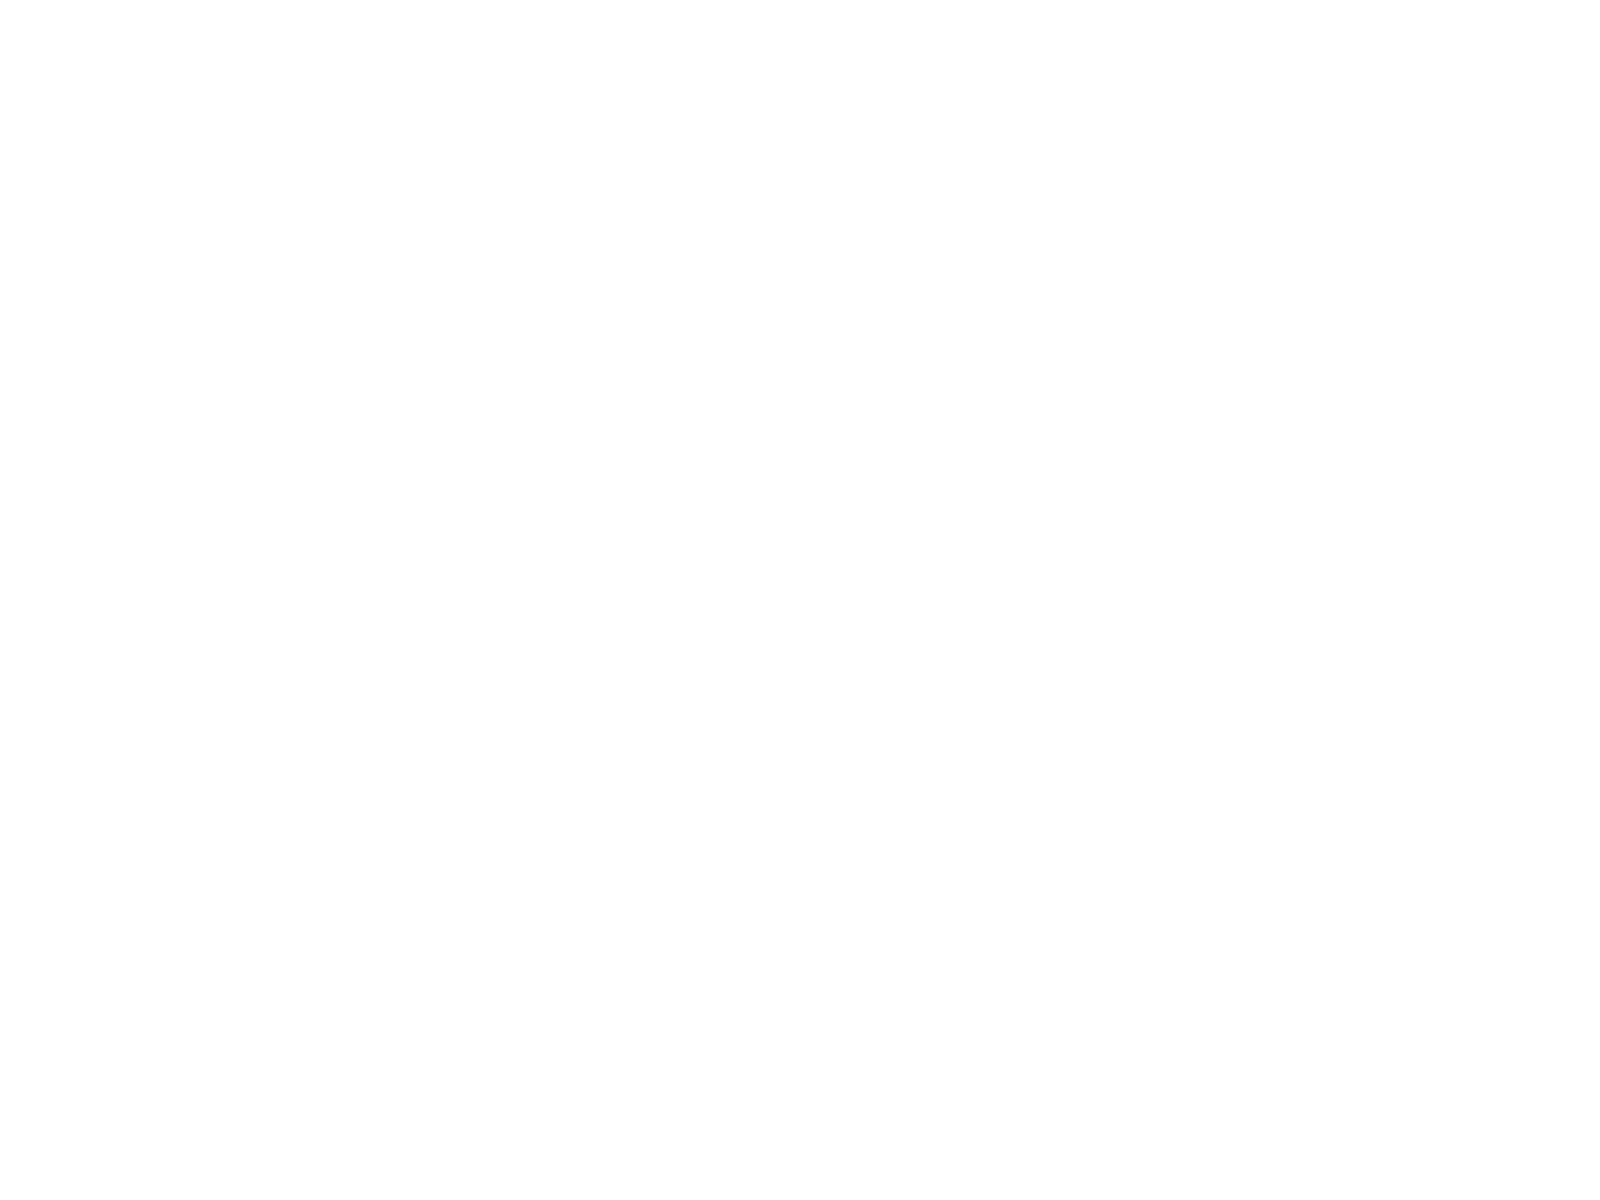

In [9]:
%matplotlib notebook
scenes = []
scenes.append(Scene(points=[PointsCollection(random_points)]))
scenes.append(Scene(points=[PointsCollection(random_points_on_circle)]))
scenes.append(Scene(points=[PointsCollection(random_points_on_rectangle)]))
scenes.append(Scene(points=[PointsCollection(random_points_on_diagonals)]))

plot.draw()

In [9]:
def numpy_det(array):
    return np.linalg.det(np.array(array))

def generate_matrix_3x3(point, point_a, point_b):
    matrix = [[point_a[0], point_a[1],1], [point_b[0], point_b[1],1], [point[0], point[1],1]]
    return matrix

def classify_point(point, point_a, point_b, epsilon, matrix_generator=generate_matrix_3x3, det=numpy_det):
    determinant = det(matrix_generator(point, point_a, point_b))
    if abs(determinant) > epsilon:
        if determinant < 0:
            return -1
        else:
            return 1
    if abs(determinant) < epsilon:
        return 0
    

In [10]:
def output_to_file(data, filename="output.txt"):
    f = open(filename, "w")
    f.write(','.join(str(elem) for elem in data))
    f.close()

In [30]:
def graham(points, scn=[], output=False, measure_time=False):
    start = 0
    end = 0
    if measure_time:
        start = timer()
    sorted_points = sorted(points, key=lambda point: (point[1],point[0]))
    first_point = sorted_points[0]
    sorted_points.pop(0)
    sorted_points = sorted(sorted_points, key = functools.cmp_to_key(lambda point_a, point_b: classify_point(first_point, point_a, point_b, 0.0001)), reverse=True)
    sorted_points = list(map(lambda point: (point[0], point[1],math.pow(point[1]-first_point[1],2)+math.pow(point[0]-first_point[0],2)), sorted_points))
    
    for i in range(0, len(sorted_points)-1):
        if i < len(sorted_points)-1:
            if sorted_points[i] == sorted_points[i+1] or classify_point(first_point,(sorted_points[i][0],sorted_points[i][1]),(sorted_points[i+1][0],sorted_points[i+1][1]),0.001) == 0:
                print(first_point,(sorted_points[i][0],sorted_points[i][1]),(sorted_points[i+1][0],sorted_points[i+1][1]))
                if(sorted_points[i][2] > sorted_points[i+1][2]):
                    del(sorted_points[i+1])
                else:
                    del(sorted_points[i])
    
    sorted_points = list(map(lambda point: (point[0], point[1]), sorted_points))
    stack = []
    stack.append(first_point)
    stack.append(sorted_points[0])
    stack.append(sorted_points[1])
    
    pnt = PointsCollection(points, color="blue")
    
    scene = Scene(points=[pnt, PointsCollection(stack, color="green")],
                  lines=[LinesCollection(get_lines(stack[0:len(stack)-1], False), color='green'),
                        LinesCollection([[(stack[-1]),(stack[-2])]], color='pink')])
    scn.append(scene)
    
    for point in sorted_points[2:len(sorted_points)]:
        scene = Scene(points=[pnt, PointsCollection(stack[0:len(stack)-1], color="green"), 
                          PointsCollection([stack[len(stack)-1],point],color="red")],
                     lines=[LinesCollection(get_lines(stack[0:len(stack)-1], False), color='green'),
                           LinesCollection([[point,stack[len(stack)-1]],[stack[len(stack)-2],stack[len(stack)-1]]], color='pink')])
        scn.append(scene)
        while len(stack) > 1 and classify_point(stack[len(stack)-2], stack[len(stack)-1], point, 0.0001) <= 0:
            stack.pop()
            
        stack.append(point)
        scene = Scene(points=[pnt, PointsCollection(stack[0:len(stack)-1], color="green"), 
                          PointsCollection([stack[len(stack)-1],point],color="red")],
                     lines=[LinesCollection(get_lines(stack[0:len(stack)-1], False), color='green'),
                           LinesCollection([[point,stack[len(stack)-1]],[stack[len(stack)-2],stack[len(stack)-1]]], color='pink')])
        scn.append(scene)
    
    scene = Scene(points=[pnt, PointsCollection(stack, color="green")],
                  lines=[LinesCollection(get_lines(stack[0:len(stack)], True), color='green')])
    scn.append(scene)
    if output:
        output_to_file(stack)
    if measure_time:
        end = timer()
        print(end-start)
    return stack

In [12]:
def jarvis(points, scn=[], output=False, measure_time=False):
    
    if measure_time:
        start = timer()
    
    hull = []
    first_point = max(points)
    hull.append(first_point)
    next_point = None
    
    pnt = PointsCollection(points, color="blue")
    
    scene = Scene(points=[pnt, PointsCollection([first_point], color="green")])
    scn.append(scene)
    
    while next_point != first_point:
        next_point = points[0]
        for point in points:
            scene = Scene(points=[pnt, PointsCollection(hull, color="green"), 
                                  PointsCollection([next_point], color="red"),
                                  PointsCollection([point], color="pink")], 
                         lines=[LinesCollection(get_lines(hull, False), color='green'),
                               LinesCollection([[next_point, hull[-1]]], color='red')])
            scn.append(scene)
            if classify_point(point, hull[-1],next_point, 0.001) > 0:
                next_point = point
                
        hull.append(next_point)
        points.remove(next_point)
    hull.pop()
    scene = Scene(points=[pnt, PointsCollection(hull, color="green"), PointsCollection([next_point], color="red")],
                 lines=[LinesCollection(get_lines(hull, True), color='green')])
    scn.append(scene)
    
    if output:
        output_to_file(hull)
        
    if measure_time:
        end = timer()
        print(end-start)
        
    return hull

In [13]:
def get_lines(points, loop=True):
    l = []
    points = list(map(lambda point: (point[0], point[1]), points))
    for i in range(0, len(points)-1):
        l.append([points[i],points[i+1]])
    if loop:
        l.append([points[len(points)-1],points[0]])
    return l

0.0034355000000232394


<IPython.core.display.Javascript object>


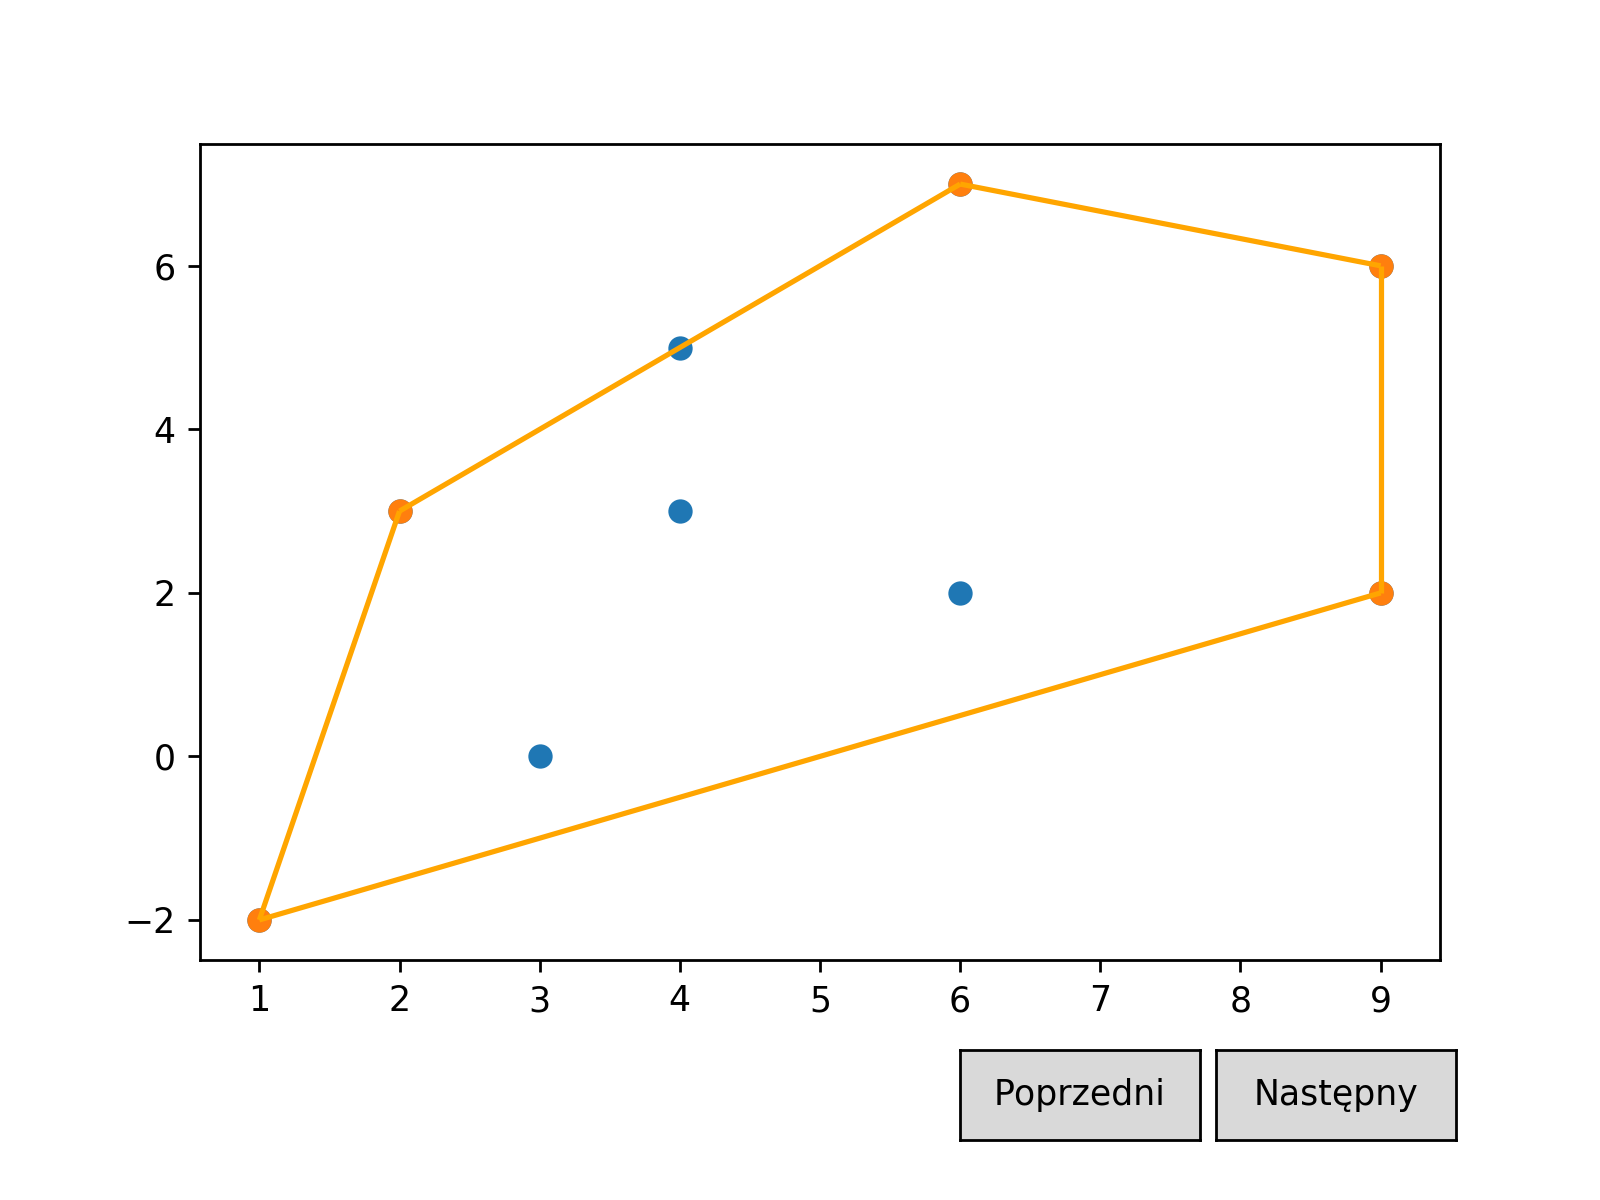

In [18]:
%matplotlib notebook
testPoints = [(1,-2),(3,0),(4,3),(6,7),(6,2),(9,2),(9,6),(4,5),(2,3)]
scenes = []
points = graham(testPoints, measure_time=True)
scenes.append(Scene(points=[PointsCollection(testPoints), PointsCollection(points)],lines=[LinesCollection(get_lines(points), 'orange')]))

points = graham(random_points, measure_time=False)
scenes.append(Scene(points=[PointsCollection(random_points), PointsCollection(points)],lines=[LinesCollection(get_lines(points), 'orange')]))

points = graham(random_points_on_circle, measure_time=False)
scenes.append(Scene(points=[PointsCollection(random_points_on_circle), PointsCollection(points)],lines=[LinesCollection(get_lines(points), 'orange')]))

points = graham(random_points_on_diagonals, measure_time=False)
scenes.append(Scene(points=[PointsCollection(random_points_on_diagonals), PointsCollection(points)],lines=[LinesCollection(get_lines(points), 'orange')]))

points = graham(random_points_on_rectangle, measure_time=False)
scenes.append(Scene(points=[PointsCollection(random_points_on_rectangle), PointsCollection(points)],lines=[LinesCollection(get_lines(points), 'orange')]))

plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


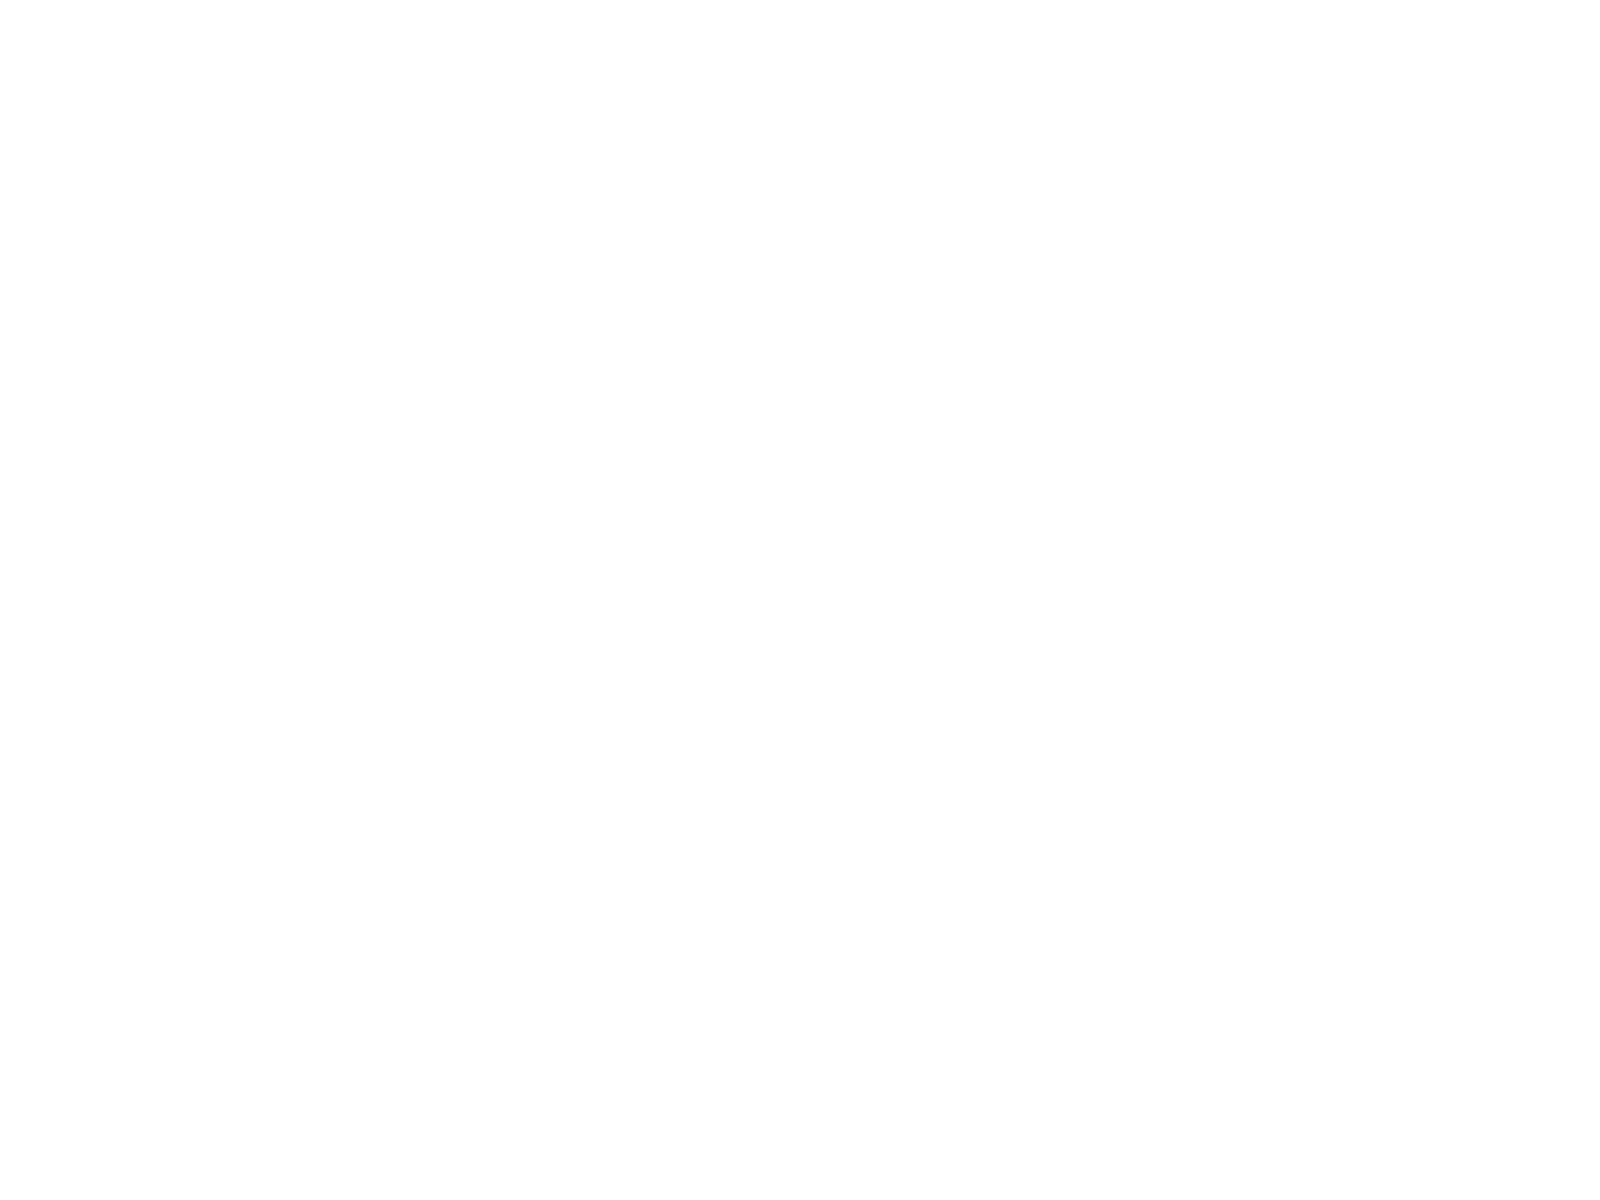

In [16]:
%matplotlib notebook
testPoints = [(1,-2),(3,0),(4,3),(6,7),(6,2),(9,2),(9,6),(4,5),(2,3)]
scenes = []
scenes.append(Scene(points=[PointsCollection(testPoints), PointsCollection(jarvis(testPoints))]))
scenes.append(Scene(points=[PointsCollection(random_points), PointsCollection(jarvis(random_points))]))
scenes.append(Scene(points=[PointsCollection(random_points_on_circle), PointsCollection(jarvis(random_points_on_circle))]))
scenes.append(Scene(points=[PointsCollection(random_points_on_diagonals), PointsCollection(jarvis(random_points_on_diagonals))]))
scenes.append(Scene(points=[PointsCollection(random_points_on_rectangle), PointsCollection(jarvis(random_points_on_rectangle))]))

plot = Plot(scenes)
plot.draw()

(1, -2) (3, 0) (9, 6)


<IPython.core.display.Javascript object>


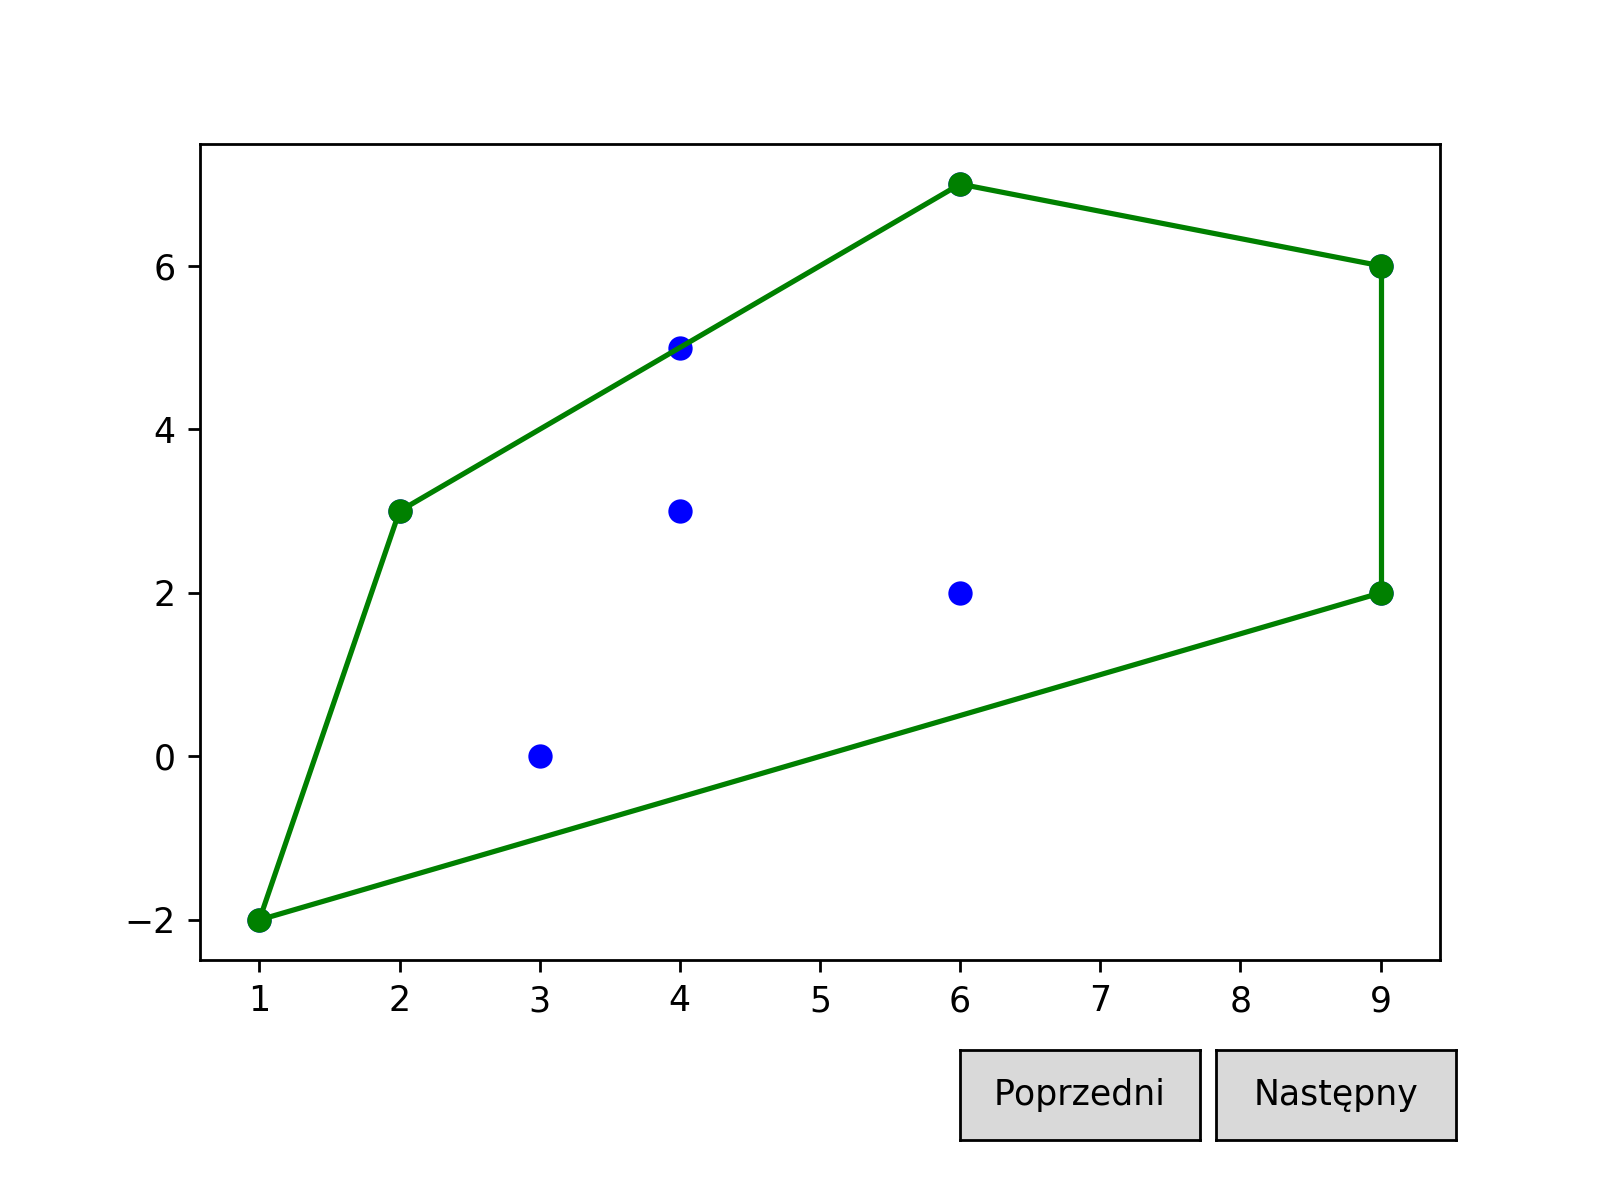

In [32]:
testPoints = [(1,-2),(3,0),(4,3),(6,7),(6,2),(9,2),(9,6),(4,5),(2,3)]
scenes = []
points = graham(testPoints, scenes, True)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


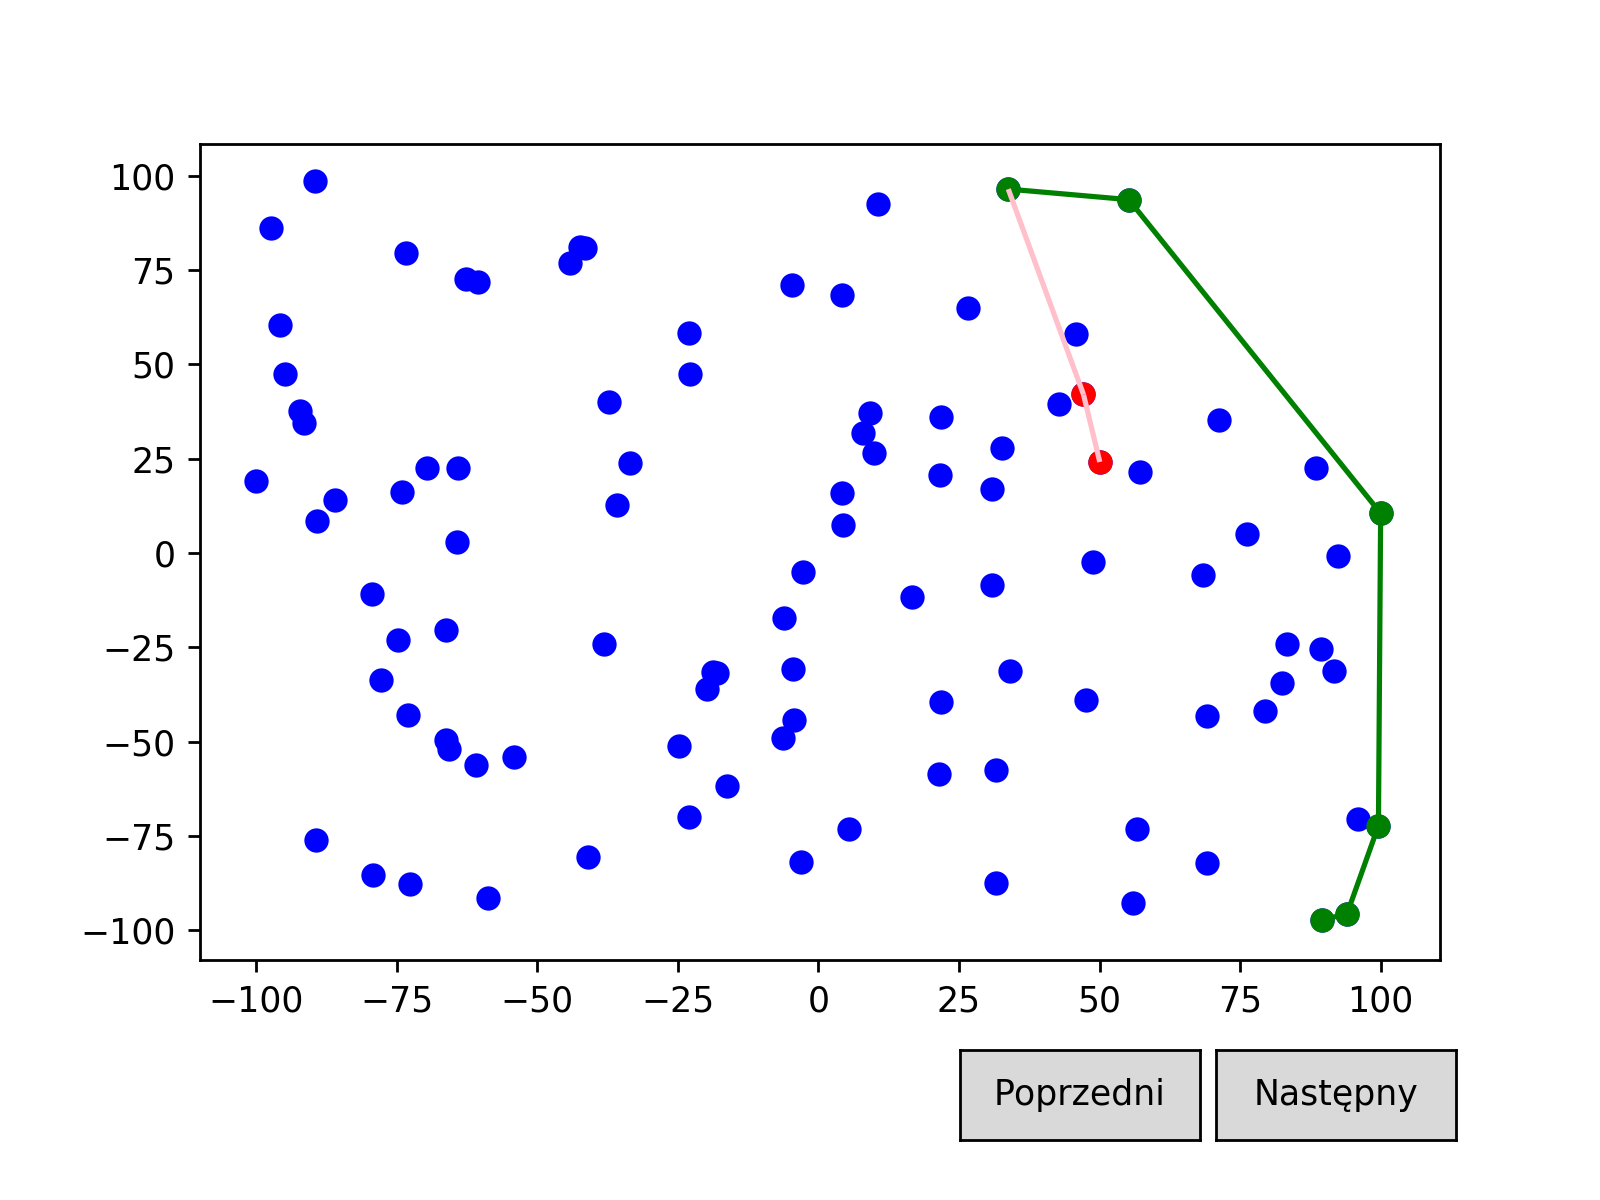

In [16]:
scenes = []
points = graham(random_points, scenes)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


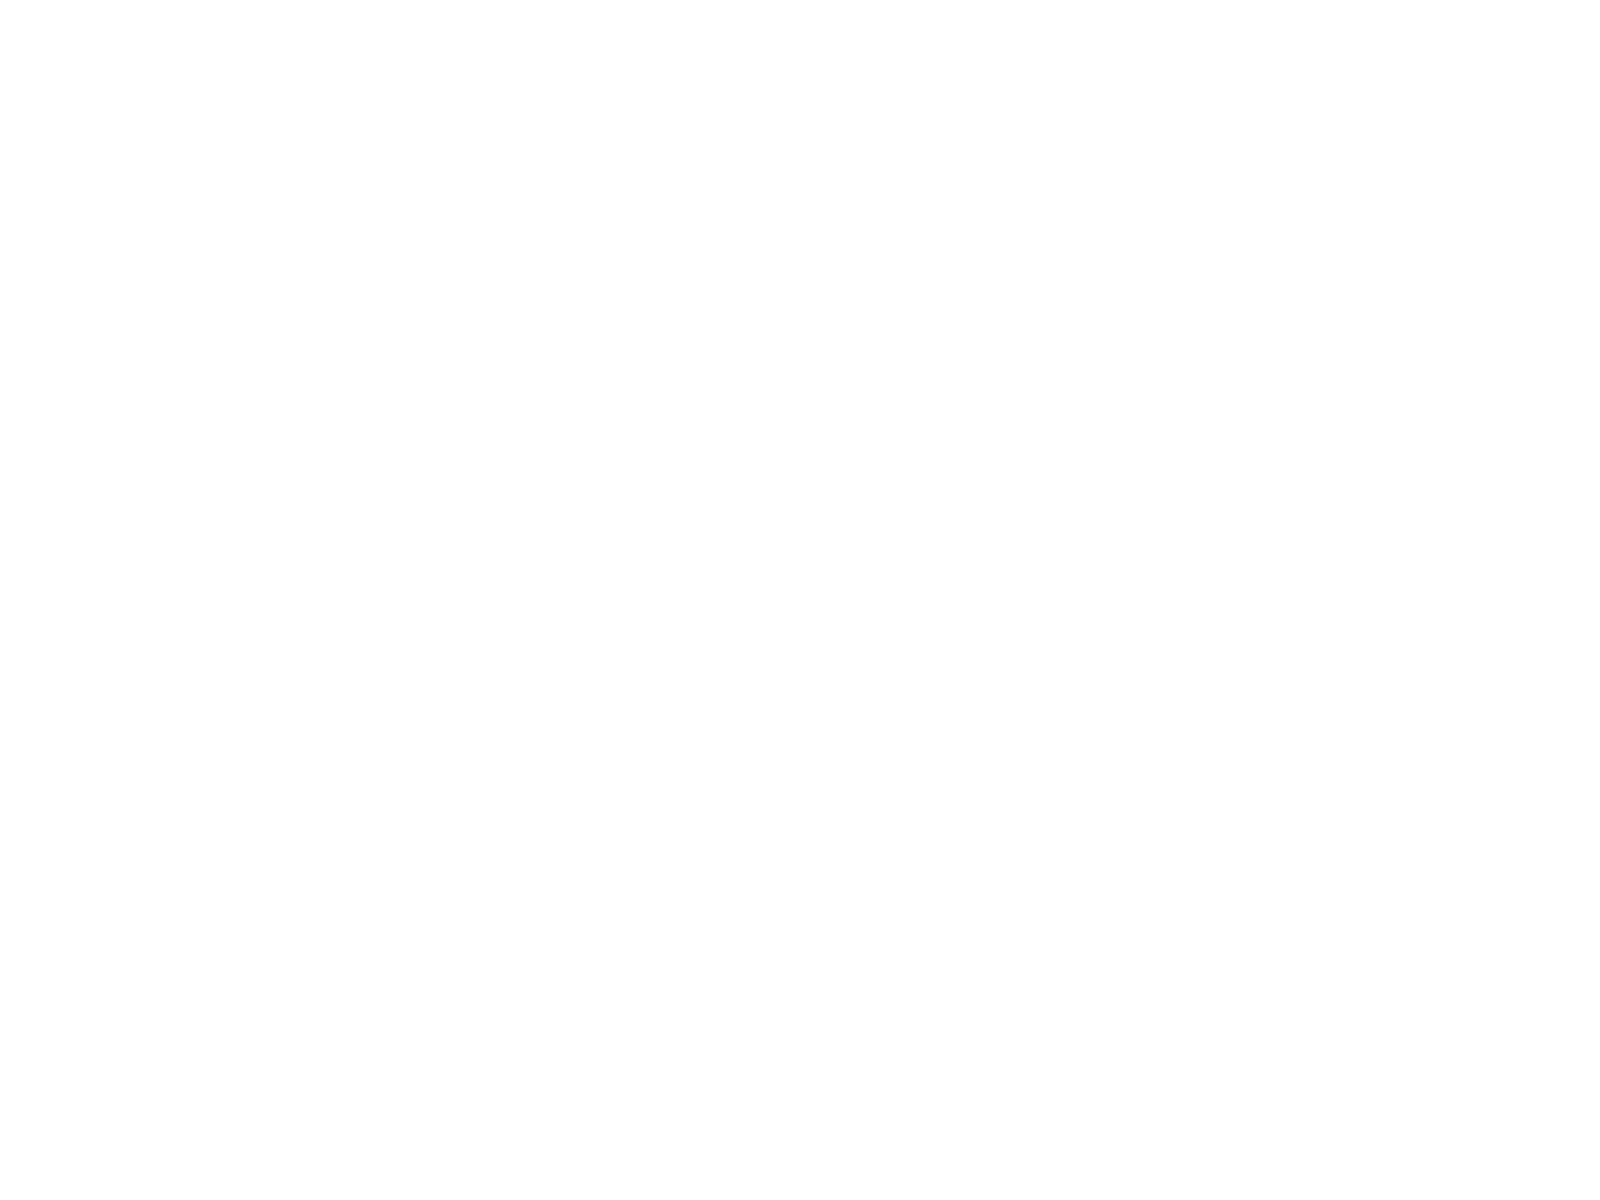

In [19]:
scenes = []
points = graham(random_points_on_circle, scenes)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


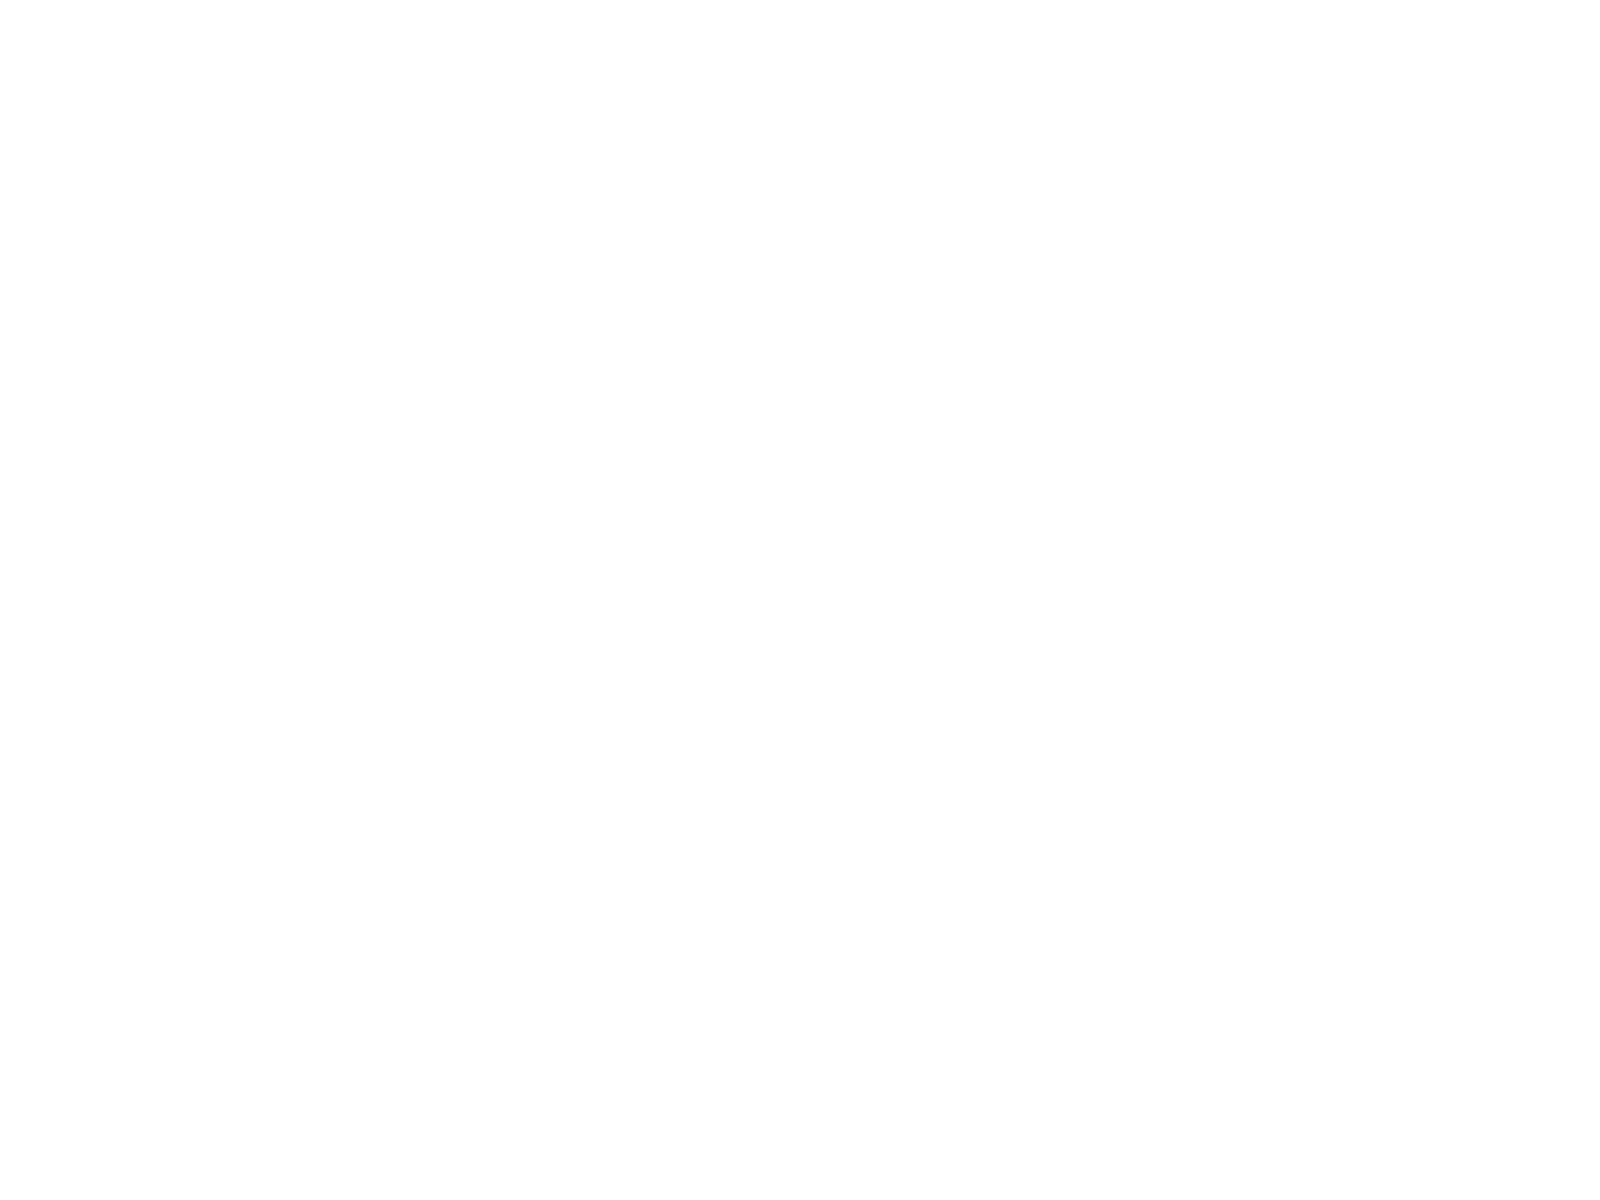

In [20]:
scenes = []
points = graham(random_points_on_diagonals, scenes)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


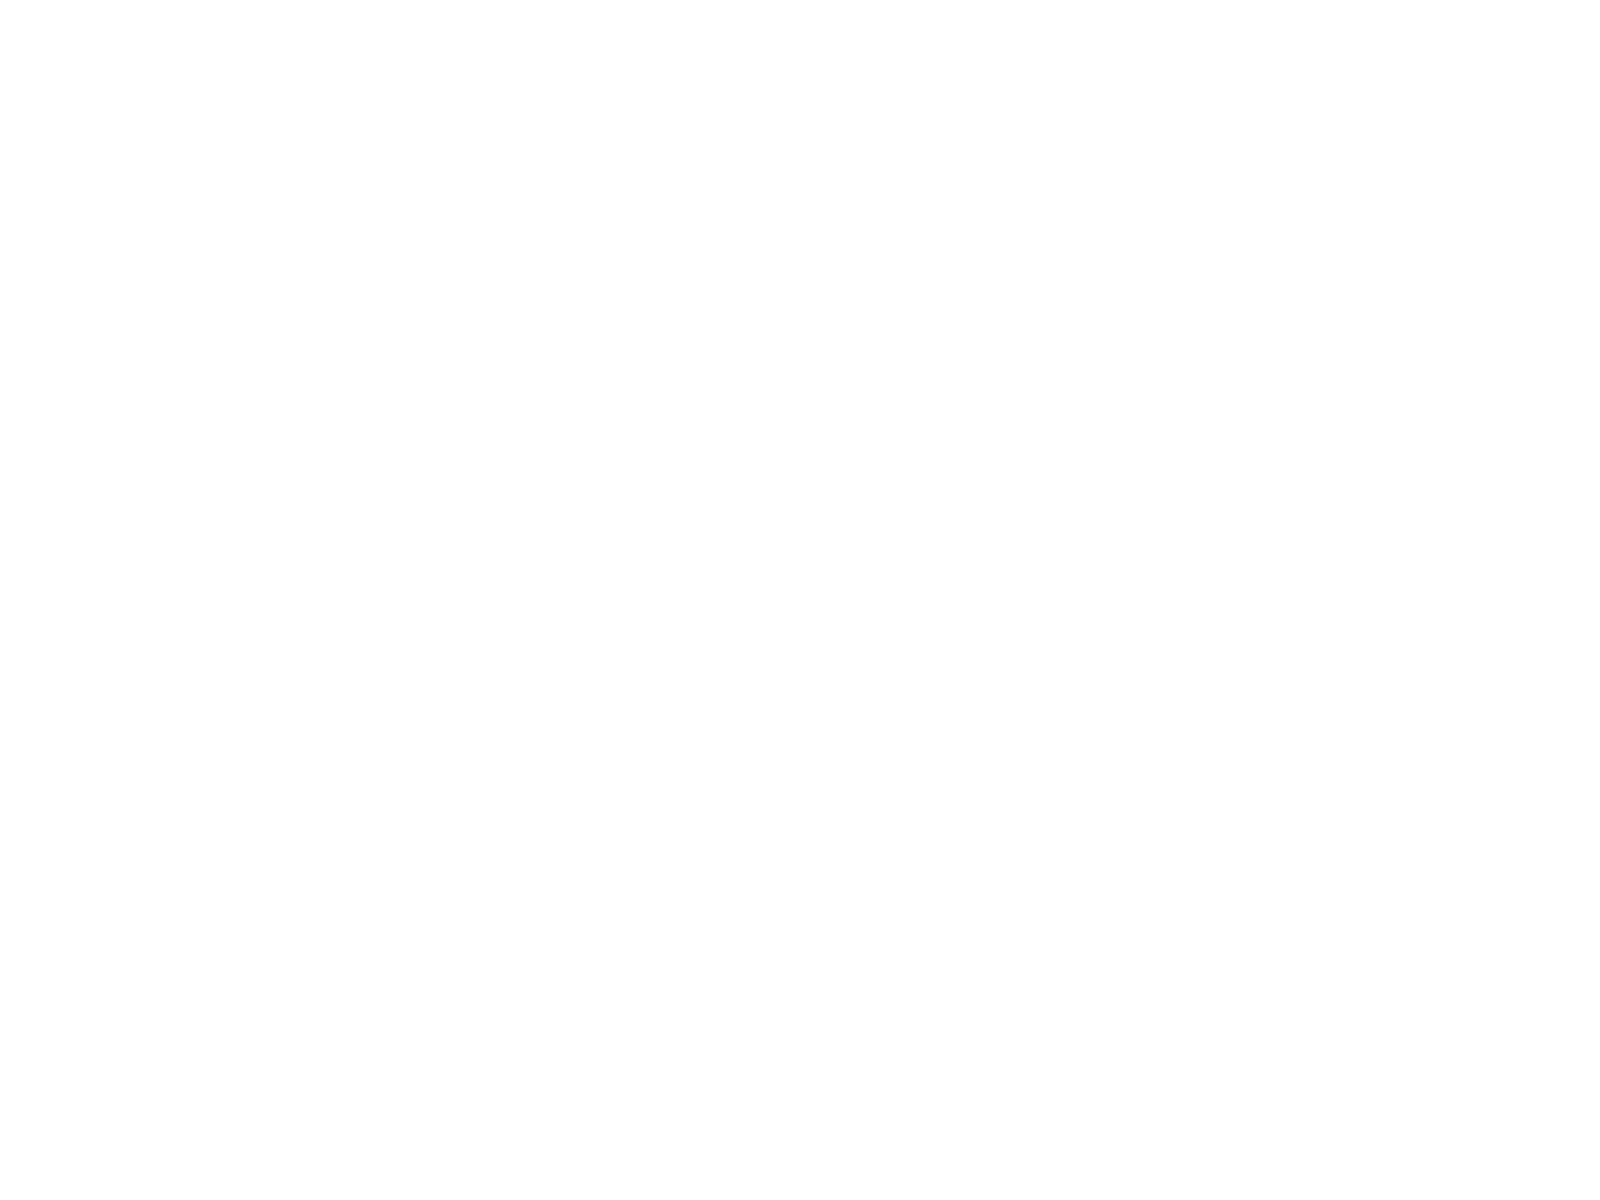

In [21]:
scenes = []
points = graham(random_points_on_rectangle, scenes)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


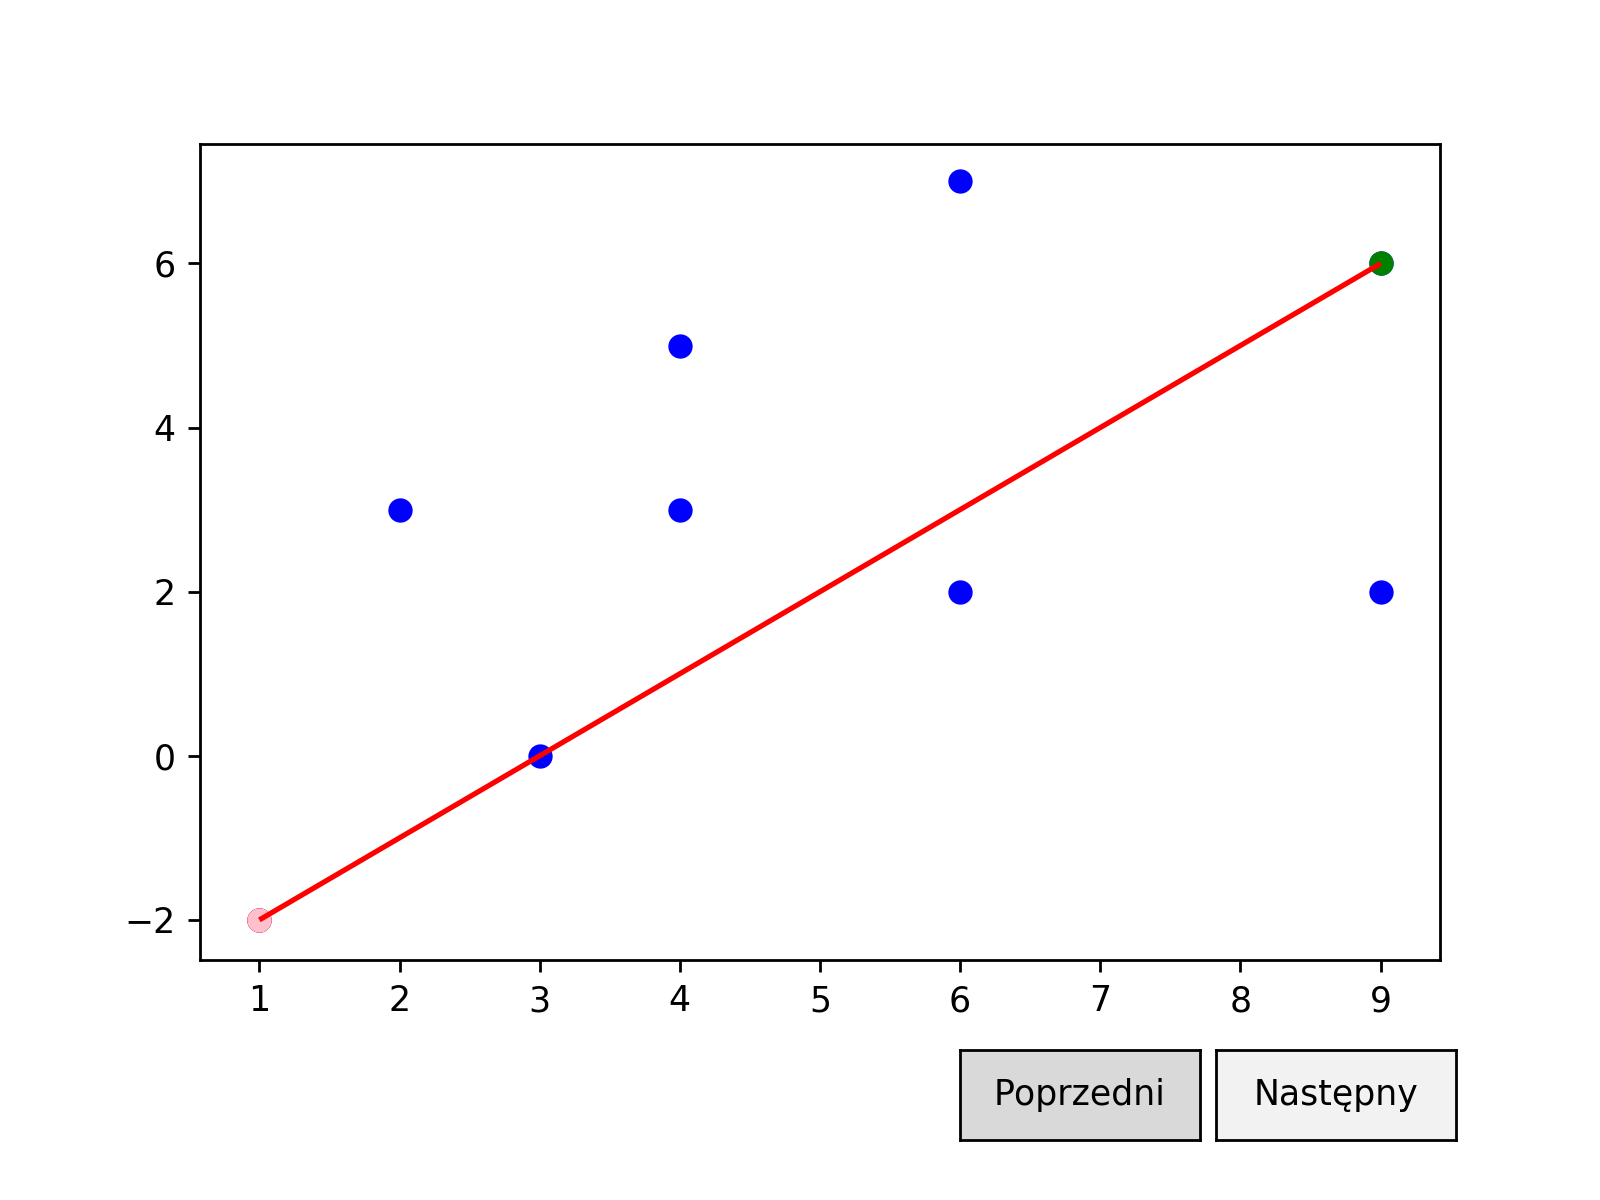

In [33]:
testPoints = [(1,-2),(3,0),(4,3),(6,7),(6,2),(9,2),(9,6),(4,5),(2,3)]
scenes = []
points = jarvis(testPoints, scenes)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


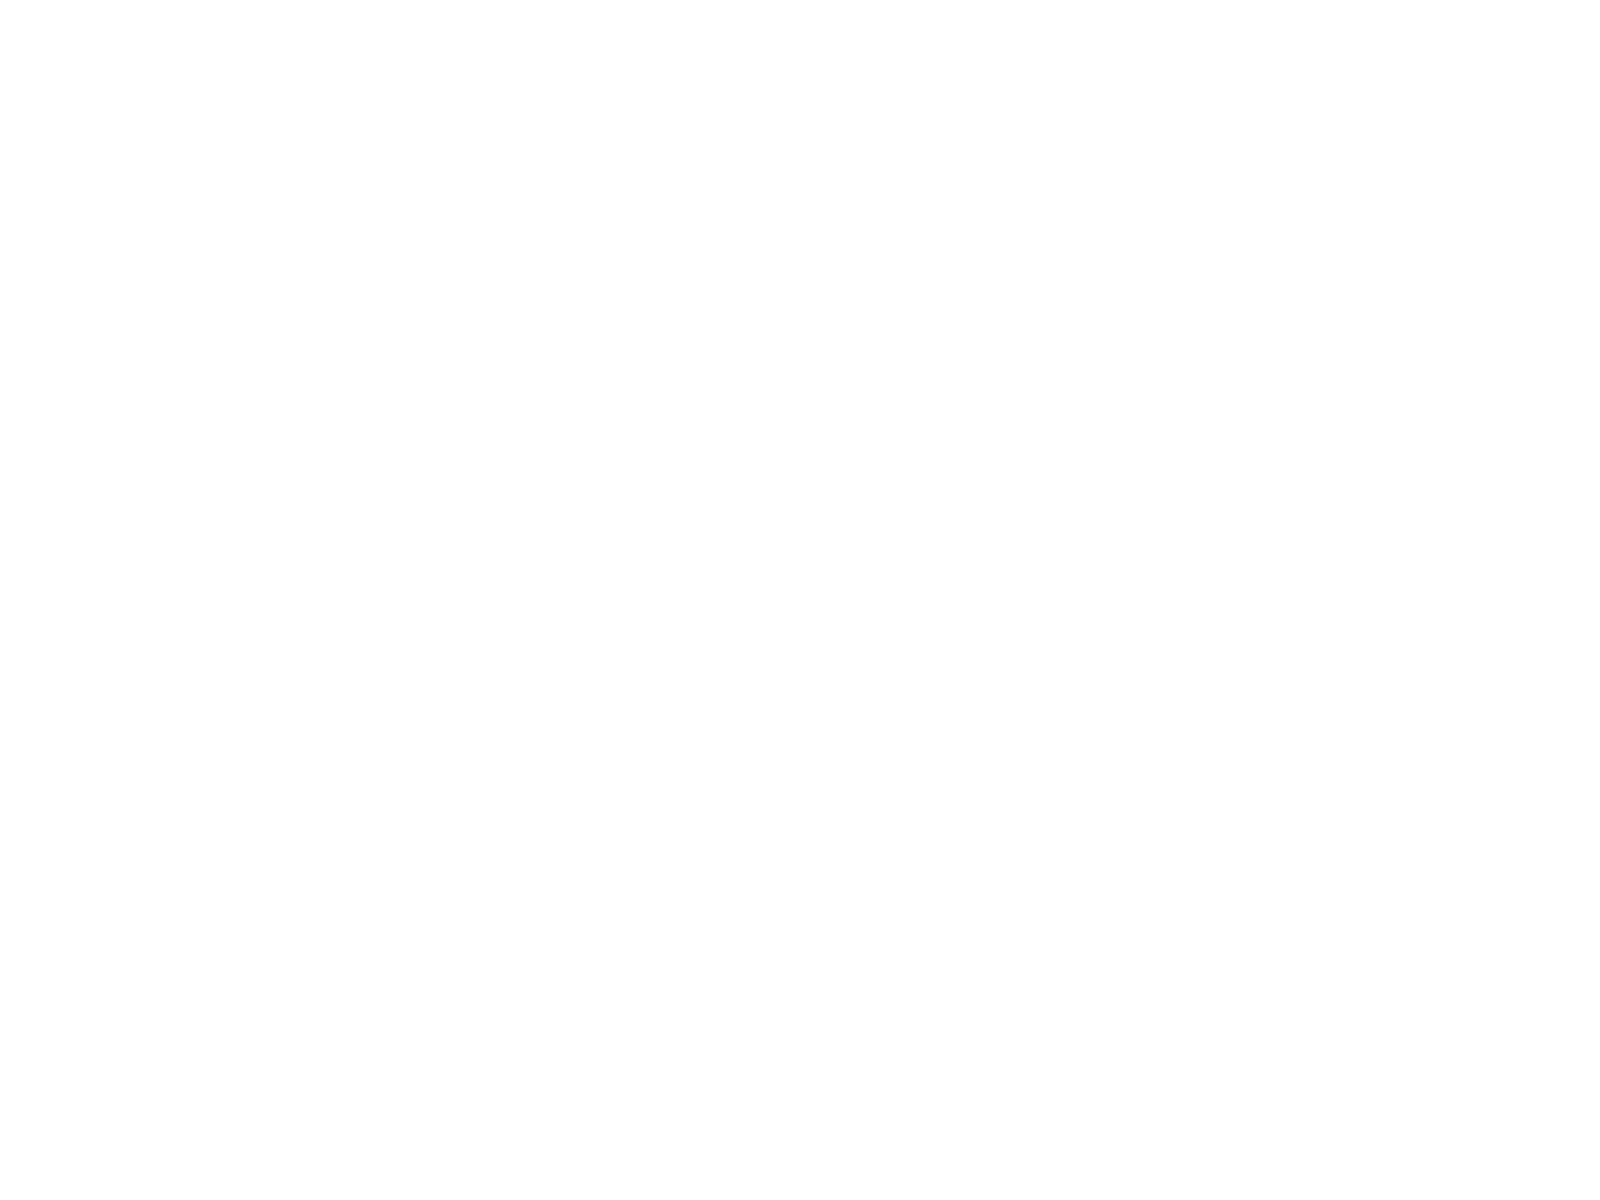

In [23]:
scenes = []
points = jarvis(random_points, scenes)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


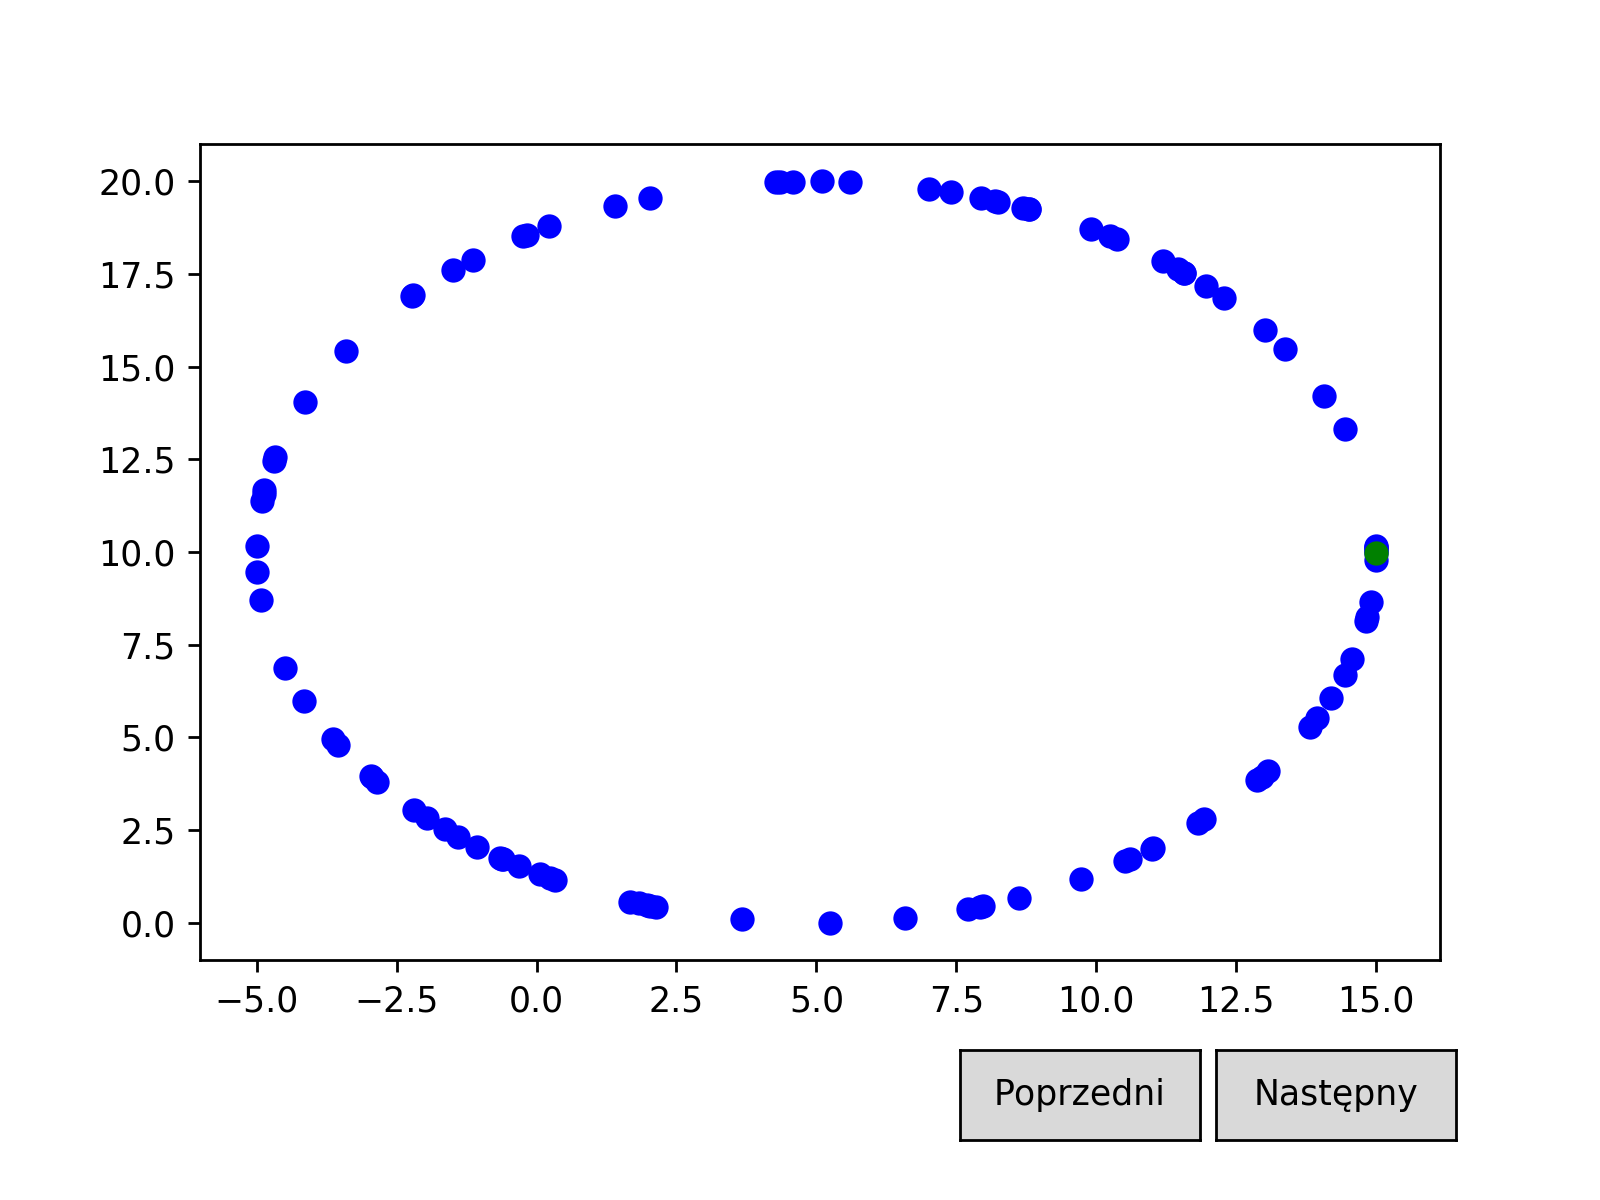

In [34]:
scenes = []
points = jarvis(random_points_on_circle, scenes)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


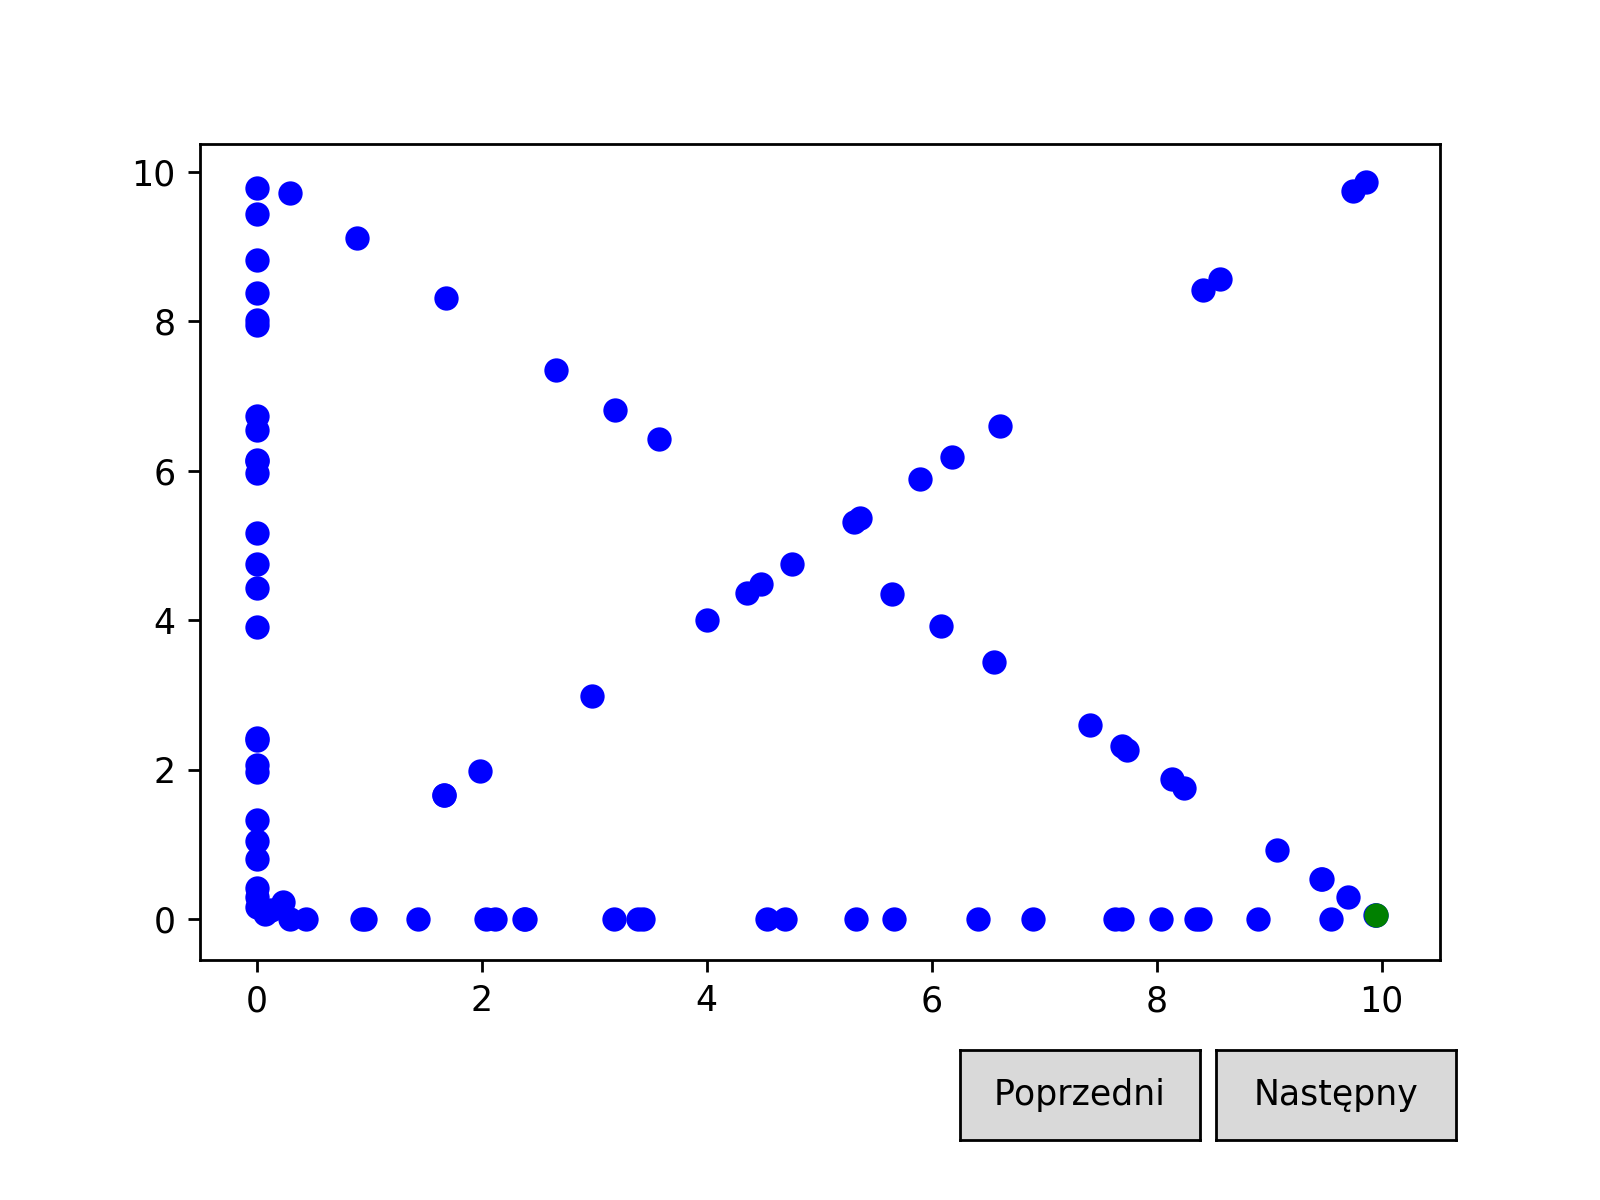

In [25]:
scenes = []
points = jarvis(random_points_on_diagonals, scenes)
plot = Plot(scenes)
plot.draw()